# Exploratory Discovery Analysis

In this notebook we explore the provided data. First, let set up the environment for the notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# DATA CONFIG
TRAIN_DATA = "data/train.csv"
EXISTING_MRT_DATA = "data/auxiliary-data/auxiliary-data/sg-mrt-existing-stations.csv"

The training data is provided in the `train.csv` file.

In [4]:
train_df = pd.read_csv(TRAIN_DATA)
train_df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


# Data Preprocessing
There are several attributes we need to normalize the values.
Let start with `flat_type`

<Axes: ylabel='count'>

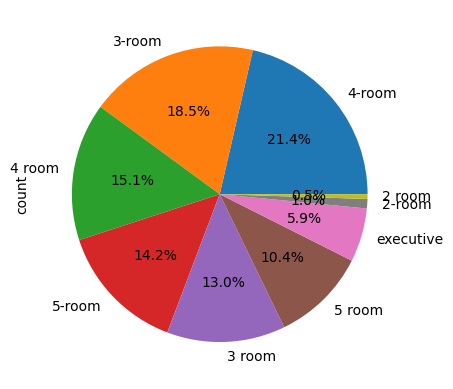

In [6]:
train_df.flat_type.value_counts().plot.pie(autopct="%1.1f%%")

We notice that there is an issue here, 2 room flat can be set as `2 room` or `2-room`. Let clean them up by removing the hyphen.

<Axes: ylabel='count'>

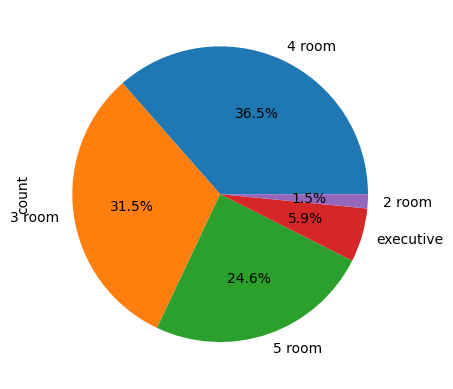

In [7]:
train_df.flat_type = train_df.flat_type.str.replace('-', ' ')
train_df.flat_type.value_counts().plot.pie(autopct="%1.1f%%")

After fixing the values, we can see the most common apartment for rent is 4 room apartments (36.5%), 3 room (31.5%) and 5 room aparments 24.6%)